In [672]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [673]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [674]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112001 entries, 0 to 2112000
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 32.2 MB


# reduce to 1 million events

In [675]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [676]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,27485,0.13,27.485
1,27687,0.13,27.687
2,27513,0.13,27.513
3,28108,0.13,28.108
4,28299,0.13,28.299
...,...,...,...
999995,28537,0.13,28.537
999996,29143,0.12,29.143
999997,29354,0.12,29.354
999998,29385,0.12,29.385


In [677]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [678]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [679]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26154633537000

### Calcul de la date de base = now - cumul_interval

In [680]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 6, 13, 16, 46, 44, 257493)

In [681]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [682]:
conso_data.iloc[0]


Interval     27485.000000
kWh              0.130000
sec             27.485000
Wh             130.980535
cumul(ms)    27485.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [683]:
base

datetime.datetime(2024, 6, 13, 16, 46, 44, 257493)

## créer les dates

In [684]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-06-13 16:47:11.742493
1        2024-06-13 16:47:39.429493
2        2024-06-13 16:48:06.942493
3        2024-06-13 16:48:35.050493
4        2024-06-13 16:49:03.349493
                    ...            
999995   2025-04-12 09:55:20.542493
999996   2025-04-12 09:55:49.685493
999997   2025-04-12 09:56:19.039493
999998   2025-04-12 09:56:48.424493
999999   2025-04-12 09:57:17.794493
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [685]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,27485,0.13,27.485,130.980535,27485,2024-06-13 16:47:11.742493,13/06/24
1,27687,0.13,27.687,130.024921,55172,2024-06-13 16:47:39.429493,13/06/24
2,27513,0.13,27.513,130.847236,82685,2024-06-13 16:48:06.942493,13/06/24
3,28108,0.13,28.108,128.077416,110793,2024-06-13 16:48:35.050493,13/06/24
4,28299,0.13,28.299,127.212976,139092,2024-06-13 16:49:03.349493,13/06/24
...,...,...,...,...,...,...,...
999995,28537,0.13,28.537,126.152013,26154516285,2025-04-12 09:55:20.542493,12/04/25
999996,29143,0.12,29.143,123.528806,26154545428,2025-04-12 09:55:49.685493,12/04/25
999997,29354,0.12,29.354,122.640867,26154574782,2025-04-12 09:56:19.039493,12/04/25
999998,29385,0.12,29.385,122.511485,26154604167,2025-04-12 09:56:48.424493,12/04/25


### save conso_data with dates

In [686]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [687]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('12/04/25', 12, 4, 2025, '09:57:32')

In [688]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [689]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1049 entries, 998951 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1049 non-null   int64         
 1   kWh        1049 non-null   float64       
 2   sec        1049 non-null   float64       
 3   Wh         1049 non-null   float64       
 4   cumul(ms)  1049 non-null   int64         
 5   dates      1049 non-null   datetime64[ns]
 6   days       1049 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 65.6+ KB


In [690]:
end = time.time()
print(end - start)

16.840116024017334


### grouped by days

In [522]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [523]:
data = list(df_grp['kWh'])
print(data)

[1.07, 3.1, 2.935, 3.698, 3.271, 3.106, 3.209, 3.401, 2.956, 3.003, 3.502, 3.636, 3.507, 3.025, 2.989, 2.088, 2.081, 2.088, 2.086, 2.08, 2.087, 2.076, 2.082, 2.079, 3.571, 3.191, 3.399, 3.854, 3.516, 3.876, 3.547, 3.528, 3.742, 3.488, 3.397, 3.271, 3.47, 3.302, 3.718, 3.694, 3.55, 3.645, 3.389, 3.25, 3.227, 2.793, 3.064, 3.666, 3.762, 3.833, 3.01, 3.335, 3.354, 3.507, 3.651, 3.66, 3.488, 3.805, 3.858, 3.681, 4.443, 4.218, 3.898, 3.912, 4.018, 3.816, 3.832, 3.71, 3.285, 3.929, 3.952, 4.434, 3.77, 4.132, 3.78, 3.966, 3.788, 3.953, 3.719, 3.59, 3.501, 3.683, 3.522, 4.127, 3.703, 3.444, 3.537, 3.265, 2.412, 1.795, 1.793, 1.792, 1.796, 2.493, 1.845, 1.788, 1.791, 1.79, 1.821, 1.822, 1.815, 1.817, 1.818, 1.818, 1.816, 1.812, 1.785, 1.787, 1.785, 1.786, 1.783, 1.796, 1.789, 1.789, 1.785, 1.796, 1.802, 1.796, 1.804, 1.795, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.826, 3.988, 3.64, 3.923, 3.092, 3.639, 3.964, 3.439, 3.416, 3.942, 3.335, 4.179, 3.07, 4.035, 3.13

In [524]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [525]:
end = time.time()
print(end - start)

18.921258211135864


### plot function by day
#### show('dd/mm/yy')

In [526]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


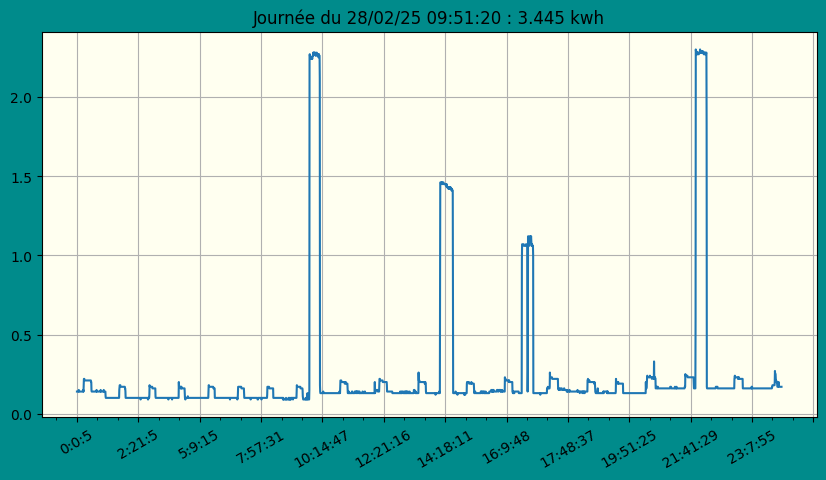

In [527]:
show('28/02/25')

In [528]:
end = time.time()
print(end - start)

20.040319442749023


### 1 kWh window in data of one day
#### df = conso_day

In [529]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998964,29034,0.12,29.034,123.992560,26119160150,2025-04-12 00:00:24.153085,12/04/25
998965,27296,0.13,27.296,131.887456,26119187446,2025-04-12 00:00:51.449085,12/04/25
998966,27622,0.13,27.622,130.330896,26119215068,2025-04-12 00:01:19.071085,12/04/25
998967,28179,0.13,28.179,127.754711,26119243247,2025-04-12 00:01:47.250085,12/04/25
998968,28602,0.12,28.602,125.865324,26119271849,2025-04-12 00:02:15.852085,12/04/25
...,...,...,...,...,...,...,...
999995,28704,0.12,28.704,125.418060,26154482905,2025-04-12 09:49:06.908085,12/04/25
999996,29179,0.12,29.179,123.376401,26154512084,2025-04-12 09:49:36.087085,12/04/25
999997,29596,0.12,29.596,121.638059,26154541680,2025-04-12 09:50:05.683085,12/04/25
999998,29314,0.12,29.314,122.808215,26154570994,2025-04-12 09:50:34.997085,12/04/25


In [530]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [531]:
df = conso_day
len(df)

1036

In [532]:
period()  # first kWh

2025-04-12 00:00:24.153085	2025-04-12 09:33:00.907085	9h 32m 36s 	1000


In [533]:
period(p=2) # second period

2025-04-12 09:33:00.907085	2025-04-12 09:51:04.628085	0h 18m 3s 	36


In [534]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.29066
dtype: float64

In [535]:
end = time.time()
print(end - start)

20.502091646194458


## mean for data grouped by days

In [536]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.289474
dtype: float64

In [537]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.036)

# conso by date


In [538]:
# select day
day = today

#day = '16/08/24'
day

'12/04/25'

In [539]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998964,29034,0.12,29.034,123.992560,26119160150,2025-04-12 00:00:24.153085,12/04/25
998965,27296,0.13,27.296,131.887456,26119187446,2025-04-12 00:00:51.449085,12/04/25
998966,27622,0.13,27.622,130.330896,26119215068,2025-04-12 00:01:19.071085,12/04/25
998967,28179,0.13,28.179,127.754711,26119243247,2025-04-12 00:01:47.250085,12/04/25
998968,28602,0.12,28.602,125.865324,26119271849,2025-04-12 00:02:15.852085,12/04/25
...,...,...,...,...,...,...,...
999995,28704,0.12,28.704,125.418060,26154482905,2025-04-12 09:49:06.908085,12/04/25
999996,29179,0.12,29.179,123.376401,26154512084,2025-04-12 09:49:36.087085,12/04/25
999997,29596,0.12,29.596,121.638059,26154541680,2025-04-12 09:50:05.683085,12/04/25
999998,29314,0.12,29.314,122.808215,26154570994,2025-04-12 09:50:34.997085,12/04/25


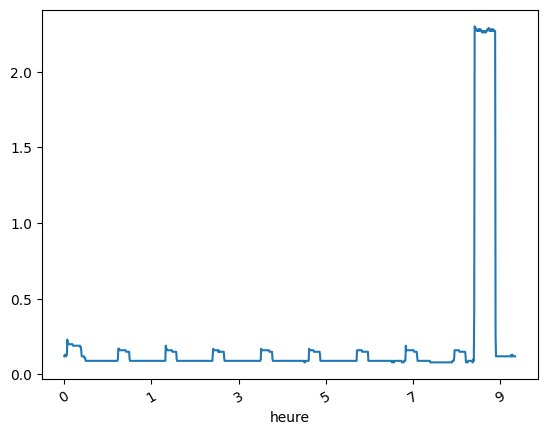

In [540]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [541]:
end = time.time()
print(end - start)

21.07016086578369


### grouped by 'heure'

In [542]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1036 entries, 998964 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1036 non-null   int64         
 1   kWh        1036 non-null   float64       
 2   sec        1036 non-null   float64       
 3   Wh         1036 non-null   float64       
 4   cumul(ms)  1036 non-null   int64         
 5   dates      1036 non-null   datetime64[ns]
 6   days       1036 non-null   object        
 7   heure      1036 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 72.8+ KB


In [543]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,29034,0.12,29.034,123.992560,26119160150,2025-04-12 00:00:24.153085,12/04/25
0,27296,0.13,27.296,131.887456,26119187446,2025-04-12 00:00:51.449085,12/04/25
0,27622,0.13,27.622,130.330896,26119215068,2025-04-12 00:01:19.071085,12/04/25
0,28179,0.13,28.179,127.754711,26119243247,2025-04-12 00:01:47.250085,12/04/25
0,28602,0.12,28.602,125.865324,26119271849,2025-04-12 00:02:15.852085,12/04/25
...,...,...,...,...,...,...,...
9,28704,0.12,28.704,125.418060,26154482905,2025-04-12 09:49:06.908085,12/04/25
9,29179,0.12,29.179,123.376401,26154512084,2025-04-12 09:49:36.087085,12/04/25
9,29596,0.12,29.596,121.638059,26154541680,2025-04-12 09:50:05.683085,12/04/25


In [544]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [545]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    111
1    101
2     99
3    100
4    100
5     98
6     98
7     95
8     88
9    146
Name: kWh, dtype: int64

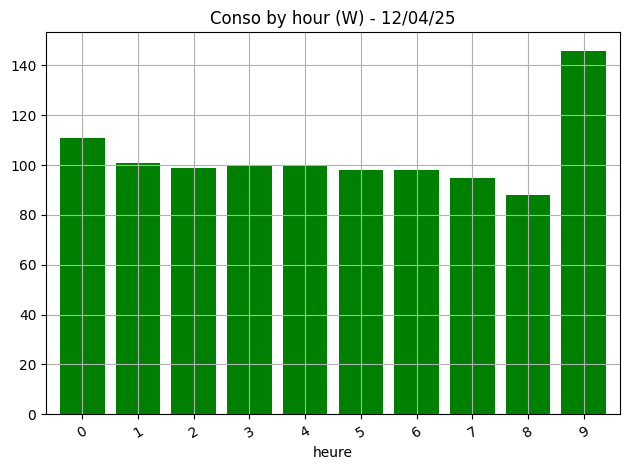

In [546]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [547]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 13/06/24 to 12/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     304 non-null    float64
dtypes: float64(1)
memory usage: 4.8+ KB


In [548]:
# give the periods of 1 kwh in a day
period()

2025-04-12 00:00:24.153085	2025-04-12 09:33:00.907085	9h 32m 36s 	1000


In [549]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-04-12 00:00:24.153085'),
 Timestamp('2025-04-12 09:33:31.680085'))

In [550]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [551]:
df_grp.mean()


kWh    3.289474
dtype: float64

In [552]:
df_grp.head()


,kWh
days,
13/06/24,1.070
14/06/24,3.100
15/06/24,2.935
16/06/24,3.698
17/06/24,3.271


In [553]:
df_grp.tail()


,kWh
days,
08/04/25,3.238
09/04/25,3.037
10/04/25,2.499
11/04/25,3.260
12/04/25,1.036


In [554]:
end = time.time()
print(end - start)

22.142698526382446


# plot les 100 derniers jours


In [555]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.5734
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

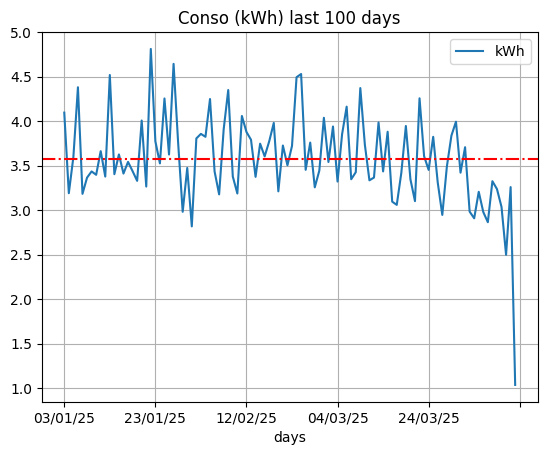

In [556]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label='moyenne')
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [557]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.036
max,4.813


In [558]:
end = time.time()
print(end - start)

22.673654794692993


In [559]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('13/03/25', '07/04/25')

In [560]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.3811
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

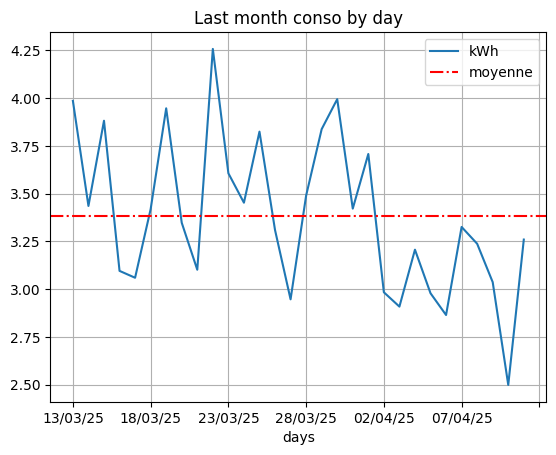

In [561]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label='moyenne')
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [562]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 22/03/25 4.258
Min : 10/04/25 2.499


# Temps de conso par tranche de 1 kWh

In [563]:

tranches = len(df)//1000
tranches+1


2

In [564]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-12 00:00:24.153085	2025-04-12 09:33:00.907085	9h 32m 36s 	1000
2025-04-12 09:33:00.907085	2025-04-12 09:51:04.628085	0h 18m 3s 	36


('09:51:20', 1.036, 1036)

In [565]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1036 entries, 998964 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1036 non-null   int64         
 1   kWh        1036 non-null   float64       
 2   sec        1036 non-null   float64       
 3   Wh         1036 non-null   float64       
 4   cumul(ms)  1036 non-null   int64         
 5   dates      1036 non-null   datetime64[ns]
 6   days       1036 non-null   object        
 7   heure      1036 non-null   object        
 8   hours      1036 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 80.9+ KB


In [566]:
conso_hours['heure'], conso_hours['hours']

(998964    0
 998965    0
 998966    0
 998967    0
 998968    0
          ..
 999995    9
 999996    9
 999997    9
 999998    9
 999999    9
 Name: heure, Length: 1036, dtype: object,
 998964    00
 998965    00
 998966    00
 998967    00
 998968    00
           ..
 999995    09
 999996    09
 999997    09
 999998    09
 999999    09
 Name: hours, Length: 1036, dtype: object)

In [567]:
end = time.time()
print(end - start)

23.788474798202515


# select number of days to display


In [568]:
span = 30
#df_grp.tail(span)

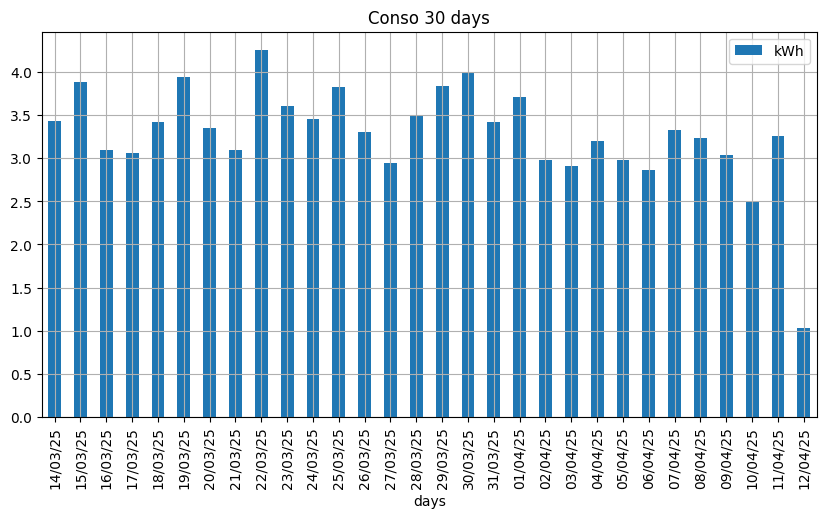

In [569]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


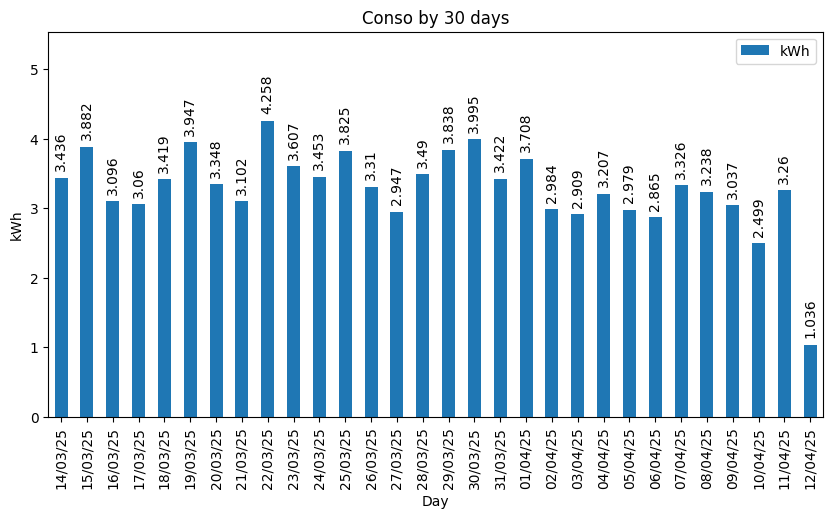

In [570]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [571]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
14/03/25    3.436
15/03/25    3.882
16/03/25    3.096
17/03/25    3.060
18/03/25    3.419
19/03/25    3.947
20/03/25    3.348
21/03/25    3.102
22/03/25    4.258
23/03/25    3.607
24/03/25    3.453
25/03/25    3.825
26/03/25    3.310
27/03/25    2.947
28/03/25    3.490
29/03/25    3.838
30/03/25    3.995
31/03/25    3.422
01/04/25    3.708
02/04/25    2.984
03/04/25    2.909
04/04/25    3.207
05/04/25    2.979
06/04/25    2.865
07/04/25    3.326
08/04/25    3.238
09/04/25    3.037
10/04/25    2.499
11/04/25    3.260
12/04/25    1.036
Name: kWh, dtype: float64

In [572]:
x_labels=df_grp.tail(span).index
x_labels

Index(['14/03/25', '15/03/25', '16/03/25', '17/03/25', '18/03/25', '19/03/25',
       '20/03/25', '21/03/25', '22/03/25', '23/03/25', '24/03/25', '25/03/25',
       '26/03/25', '27/03/25', '28/03/25', '29/03/25', '30/03/25', '31/03/25',
       '01/04/25', '02/04/25', '03/04/25', '04/04/25', '05/04/25', '06/04/25',
       '07/04/25', '08/04/25', '09/04/25', '10/04/25', '11/04/25', '12/04/25'],
      dtype='object', name='days')

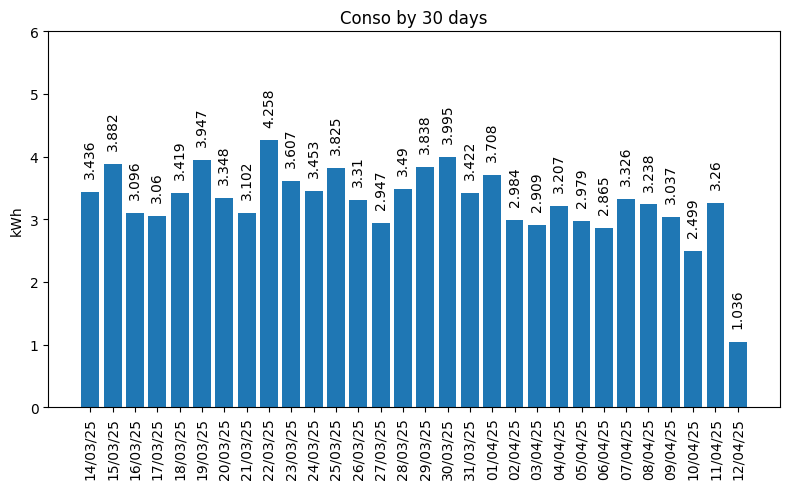

In [573]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [574]:
end = time.time()
print(end - start)

26.881651163101196


In [575]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

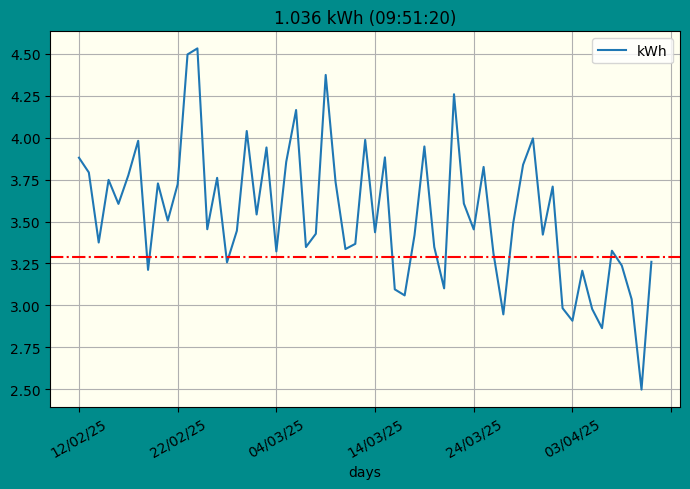

In [576]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

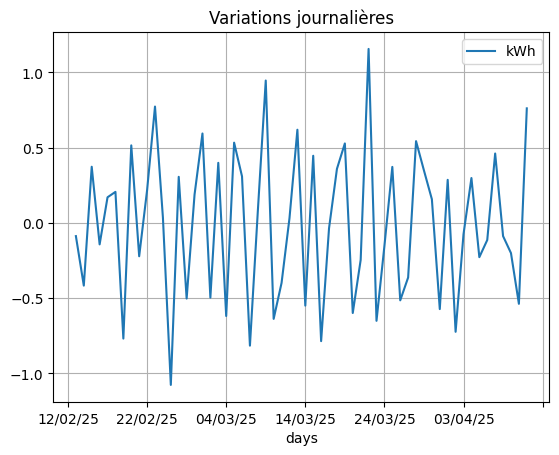

In [577]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [578]:
end = time.time()
print(end - start)

27.94405198097229


# Data from 21/08/23

In [579]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,20711,0.17,20.711,173.820675,20711,2024-06-13 16:41:24.714085,13/06/24,16,2024-06,13
1,20837,0.17,20.837,172.769593,41548,2024-06-13 16:41:45.551085,13/06/24,16,2024-06,13
2,26618,0.14,26.618,135.246825,68166,2024-06-13 16:42:12.169085,13/06/24,16,2024-06,13
3,27398,0.13,27.398,131.396452,95564,2024-06-13 16:42:39.567085,13/06/24,16,2024-06,13
4,27460,0.13,27.460,131.099782,123024,2024-06-13 16:43:07.027085,13/06/24,16,2024-06,13
...,...,...,...,...,...,...,...,...,...,...
999995,28704,0.12,28.704,125.418060,26154482905,2025-04-12 09:49:06.908085,12/04/25,09,2025-04,12
999996,29179,0.12,29.179,123.376401,26154512084,2025-04-12 09:49:36.087085,12/04/25,09,2025-04,12
999997,29596,0.12,29.596,121.638059,26154541680,2025-04-12 09:50:05.683085,12/04/25,09,2025-04,12
999998,29314,0.12,29.314,122.808215,26154570994,2025-04-12 09:50:34.997085,12/04/25,09,2025-04,12


In [580]:
end = time.time()
print(end - start)

67.02263402938843


In [581]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

In [582]:
month=conso_grouped_by_month.get_group('2025-02')

In [583]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

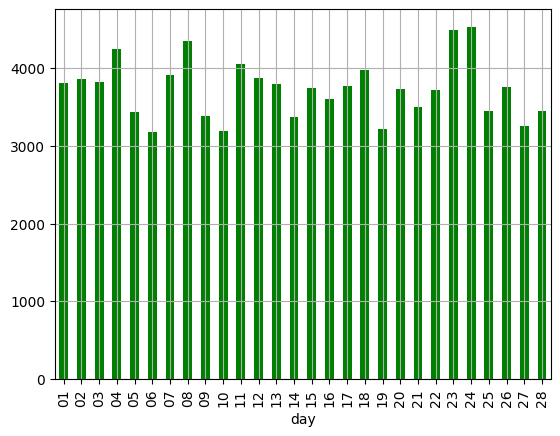

In [584]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

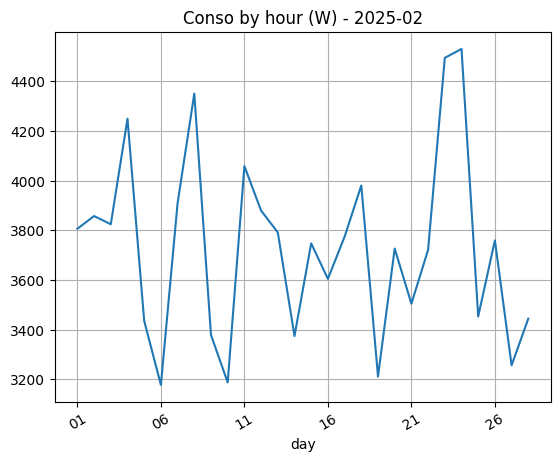

In [585]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [586]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [587]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3807,3807,3807
02,3858,3858,3858
03,3825,3825,3825
04,4250,4250,4250
05,3436,3436,3436
06,3178,3178,3178
07,3910,3910,3910
08,4351,4351,4351
09,3379,3379,3379


In [588]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [589]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [590]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-06,52665,52665,52665
2024-07,99400,99400,99400
2024-08,117327,117327,117327
2024-09,69759,69759,69759
2024-10,73539,73539,73539
2024-11,108507,108507,108507
2024-12,113778,113778,113778
2025-01,113602,113602,113602
2025-02,104505,104505,104505


In [591]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [592]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [593]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
13/06/24,1070
14/06/24,3100
15/06/24,2935
16/06/24,3698
17/06/24,3271
...,...
08/04/25,3238
09/04/25,3037
10/04/25,2499


In [594]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,20711,0.17,20.711,173.820675,20711,2024-06-13 16:41:24.714085,13/06/24,16,2024-06,13
1,20837,0.17,20.837,172.769593,41548,2024-06-13 16:41:45.551085,13/06/24,16,2024-06,13
2,26618,0.14,26.618,135.246825,68166,2024-06-13 16:42:12.169085,13/06/24,16,2024-06,13
3,27398,0.13,27.398,131.396452,95564,2024-06-13 16:42:39.567085,13/06/24,16,2024-06,13
4,27460,0.13,27.460,131.099782,123024,2024-06-13 16:43:07.027085,13/06/24,16,2024-06,13
...,...,...,...,...,...,...,...,...,...,...
999995,28704,0.12,28.704,125.418060,26154482905,2025-04-12 09:49:06.908085,12/04/25,09,2025-04,12
999996,29179,0.12,29.179,123.376401,26154512084,2025-04-12 09:49:36.087085,12/04/25,09,2025-04,12
999997,29596,0.12,29.596,121.638059,26154541680,2025-04-12 09:50:05.683085,12/04/25,09,2025-04,12
999998,29314,0.12,29.314,122.808215,26154570994,2025-04-12 09:50:34.997085,12/04/25,09,2025-04,12


In [595]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
13/06/24 16    0       13/06/24    16  0.17
               1       13/06/24    16  0.17
               2       13/06/24    16  0.14
               3       13/06/24    16  0.13
               4       13/06/24    16  0.13
...                         ...   ...   ...
12/04/25 09    999995  12/04/25    09  0.12
               999996  12/04/25    09  0.12
               999997  12/04/25    09  0.12
               999998  12/04/25    09  0.12
               999999  12/04/25    09  0.12

[1000000 rows x 3 columns]

In [596]:
groupallbyday.indices.keys()

dict_keys(['13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/0

In [597]:
groupallbydayhours.indices.keys()

dict_keys([('13/06/24', '16'), ('13/06/24', '17'), ('13/06/24', '18'), ('13/06/24', '19'), ('13/06/24', '20'), ('13/06/24', '21'), ('13/06/24', '22'), ('13/06/24', '23'), ('14/06/24', '16'), ('14/06/24', '17'), ('14/06/24', '18'), ('14/06/24', '19'), ('14/06/24', '20'), ('14/06/24', '21'), ('14/06/24', '22'), ('14/06/24', '23'), ('14/06/24', '00'), ('14/06/24', '01'), ('14/06/24', '02'), ('14/06/24', '03'), ('14/06/24', '04'), ('14/06/24', '05'), ('14/06/24', '06'), ('14/06/24', '07'), ('14/06/24', '08'), ('14/06/24', '09'), ('14/06/24', '10'), ('14/06/24', '11'), ('14/06/24', '12'), ('14/06/24', '13'), ('14/06/24', '14'), ('14/06/24', '15'), ('15/06/24', '16'), ('15/06/24', '17'), ('15/06/24', '18'), ('15/06/24', '19'), ('15/06/24', '20'), ('15/06/24', '21'), ('15/06/24', '22'), ('15/06/24', '23'), ('15/06/24', '00'), ('15/06/24', '01'), ('15/06/24', '02'), ('15/06/24', '03'), ('15/06/24', '04'), ('15/06/24', '05'), ('15/06/24', '06'), ('15/06/24', '07'), ('15/06/24', '08'), ('15/06/2

In [598]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
13/06/24,1070,1070
14/06/24,3100,3100
15/06/24,2935,2935
16/06/24,3698,3698
17/06/24,3271,3271
...,...,...
08/04/25,3238,3238
09/04/25,3037,3037
10/04/25,2499,2499


In [599]:
grp_by_day['kWh'].cumsum()

days
13/06/24       1070
14/06/24       4170
15/06/24       7105
16/06/24      10803
17/06/24      14074
             ...   
08/04/25     990168
09/04/25     993205
10/04/25     995704
11/04/25     998964
12/04/25    1000000
Name: kWh, Length: 304, dtype: int64

In [600]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
13/06/24 16      41
         17     139
         18     141
         19     174
         20     139
...             ...
12/04/25 05      98
         06      98
         07      95
         08      88
         09     146

[7266 rows x 1 columns]

In [601]:
grp_by_dayhours['kWh'].cumsum()

days      hours
13/06/24  16            41
          17           180
          18           321
          19           495
          20           634
                    ...   
12/04/25  05        999573
          06        999671
          07        999766
          08        999854
          09       1000000
Name: kWh, Length: 7266, dtype: int64

In [602]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
13/06/24 16      41      41   NaN
         17     139     180  98.0
         18     141     321   2.0
         19     174     495  33.0
         20     139     634 -35.0
...             ...     ...   ...
12/04/25 05      98     609  -2.0
         06      98     707   0.0
         07      95     802  -3.0
         08      88     890  -7.0
         09     146    1036  58.0

[7266 rows x 3 columns]

In [603]:
today, grp_by_dayhours.loc[today]

('12/04/25',
        kWh  cumsum  diff
 hours                   
 00     111     111   NaN
 01     101     212 -10.0
 02      99     311  -2.0
 03     100     411   1.0
 04     100     511   0.0
 05      98     609  -2.0
 06      98     707   0.0
 07      95     802  -3.0
 08      88     890  -7.0
 09     146    1036  58.0)

Text(0.5, 1.0, 'Cumul journalier')

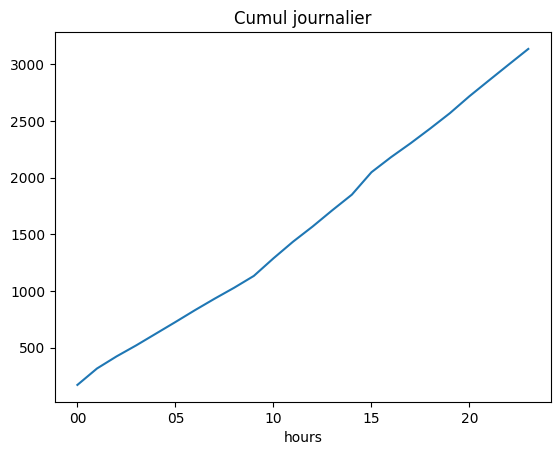

In [604]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

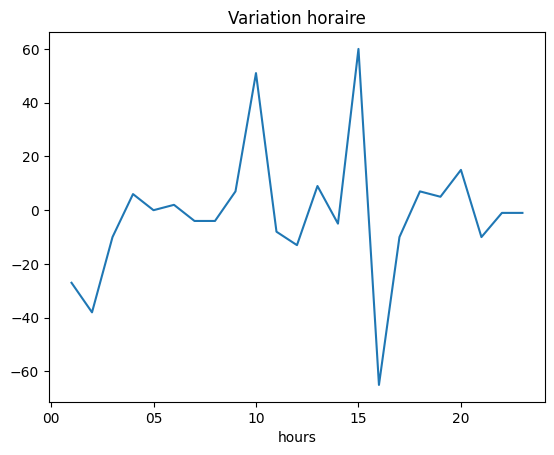

In [605]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [606]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

304

In [607]:
df_grp.tail(n)['kWh'].describe()


count    304.000000
mean       3.289474
std        0.768779
min        1.036000
25%        3.099000
50%        3.453500
75%        3.782000
max        4.817000
Name: kWh, dtype: float64

In [608]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [609]:
n, np.nanmean(df_grp.tail(n))

(304, np.float64(3.289473684210526))

Text(0.5, 1.0, '304 days')

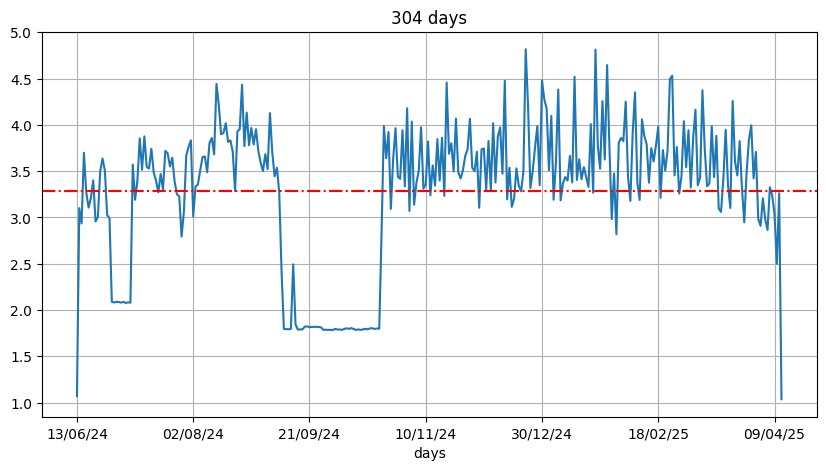

In [610]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

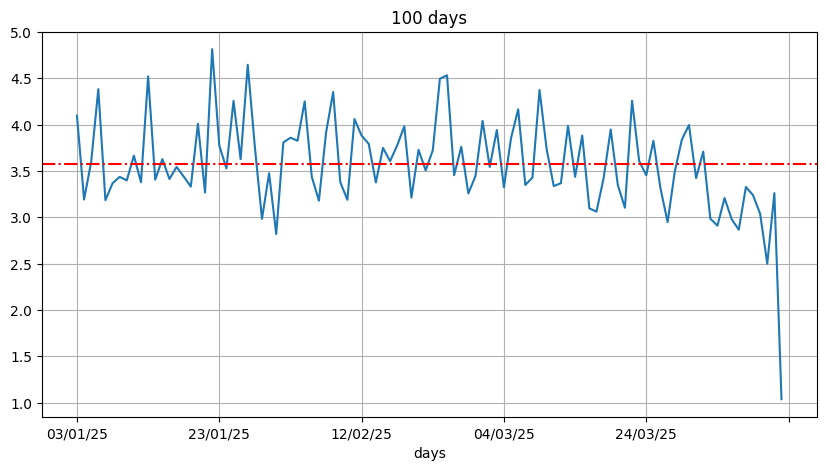

In [611]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [612]:
np.nanmean(df_grp.tail(span))

np.float64(3.5734000000000004)

In [613]:
df_grp['kWh']

days
13/06/24    1.070
14/06/24    3.100
15/06/24    2.935
16/06/24    3.698
17/06/24    3.271
            ...  
08/04/25    3.238
09/04/25    3.037
10/04/25    2.499
11/04/25    3.260
12/04/25    1.036
Name: kWh, Length: 304, dtype: float64

In [614]:
df_grp.describe()

,kWh
count,304.000000
mean,3.289474
std,0.768779
min,1.036000
25%,3.099000
50%,3.453500
75%,3.782000
max,4.817000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

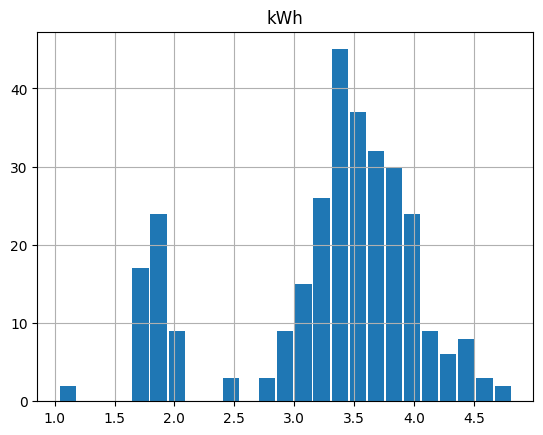

In [615]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [616]:
df_grp.tail(span)['kWh']

days
03/01/25    4.097
04/01/25    3.191
05/01/25    3.597
06/01/25    4.382
07/01/25    3.184
            ...  
08/04/25    3.238
09/04/25    3.037
10/04/25    2.499
11/04/25    3.260
12/04/25    1.036
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [617]:
day

'12/04/25'

In [618]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,111,111,NaN
01,101,212,-10.0
02,99,311,-2.0
03,100,411,1.0
04,100,511,0.0
05,98,609,-2.0
06,98,707,0.0
07,95,802,-3.0
08,88,890,-7.0


In [619]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [620]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [621]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [622]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [623]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [624]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [625]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [626]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [627]:
day

'12/04/25'

In [628]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,111,111,NaN,1.0
01,101,212,-10.0,2.0
02,99,311,-2.0,3.0
03,100,411,1.0,4.0
04,100,511,0.0,5.0
05,98,609,-2.0,6.0
06,98,707,0.0,7.0
07,95,802,-3.0,8.0
08,88,890,-7.0,9.0


In [629]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_6056\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(1036)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '12/04/25: kWh    1036\ndtype: int64')

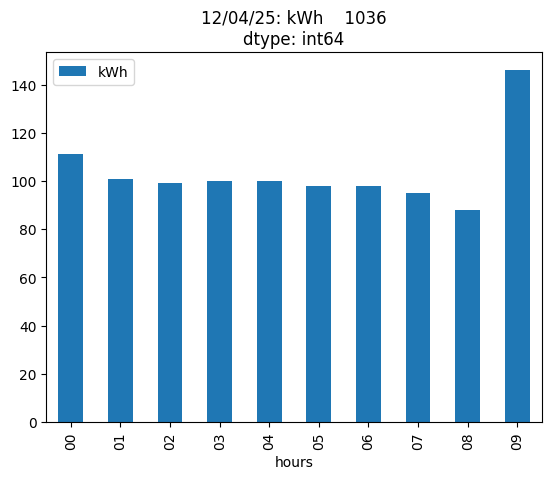

In [630]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [631]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [632]:

grp_by_dayhours.count()

kWh       7266
cumsum    7266
diff      6962
days        10
dtype: int64

'23/12/24'

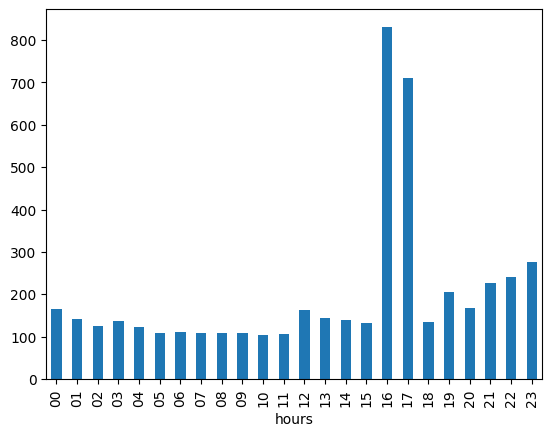

In [633]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [634]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [635]:
df_grp.tail(7)['kWh']

days
06/04/25    2.865
07/04/25    3.326
08/04/25    3.238
09/04/25    3.037
10/04/25    2.499
11/04/25    3.260
12/04/25    1.036
Name: kWh, dtype: float64

Total= 357.34 , Moyenne= 3.5734000000000004


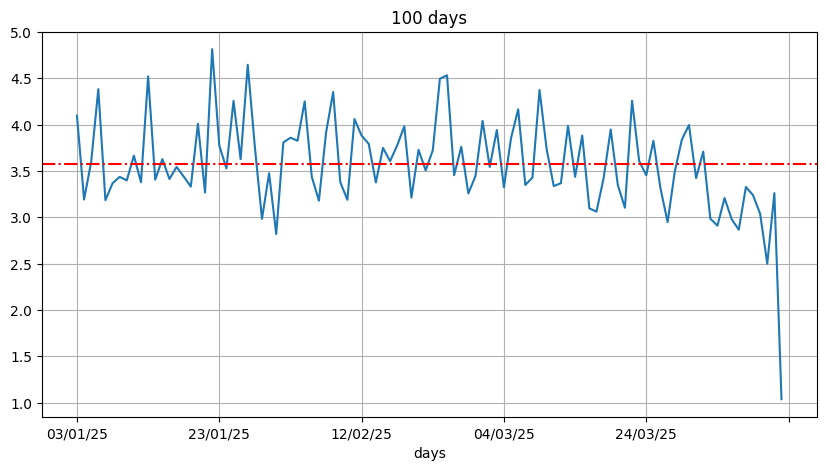

In [636]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [637]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

80.96824932098389


# Today

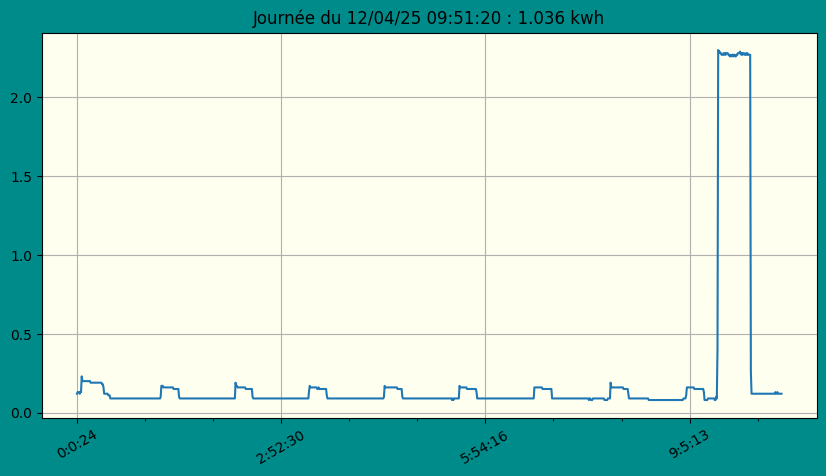

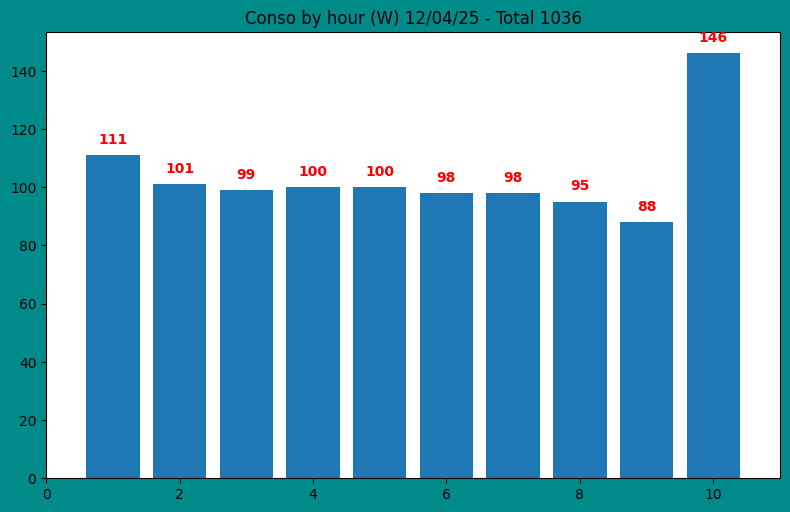

In [638]:
show(today,bgcolor='ivory')
conso_by_hour(today)

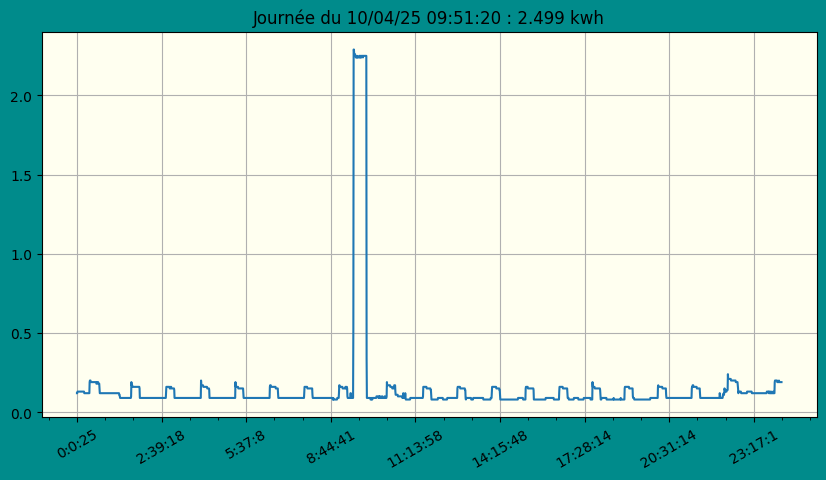

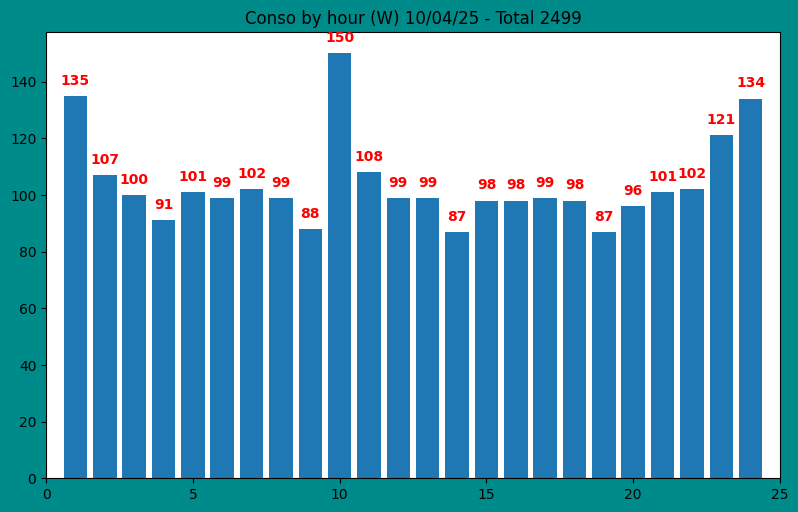

In [639]:
day = '10/04/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4817)

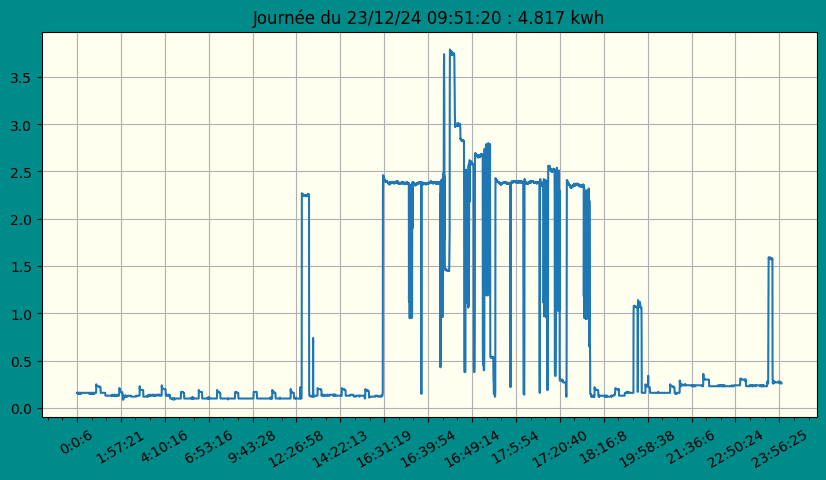

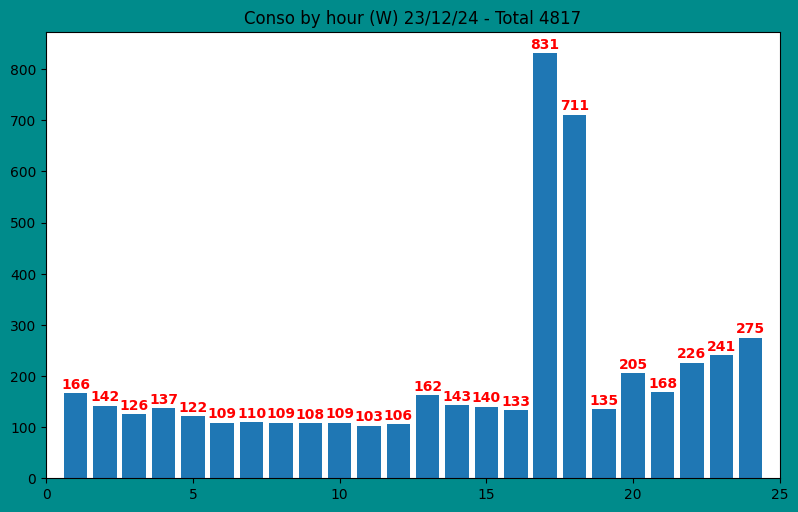

In [640]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

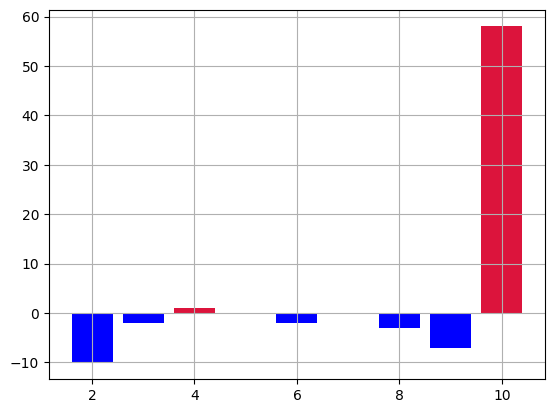

In [641]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

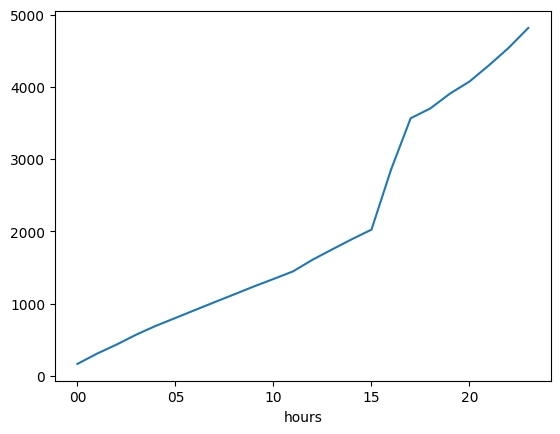

In [642]:
data.cumsum().plot()


<Axes: xlabel='hours'>

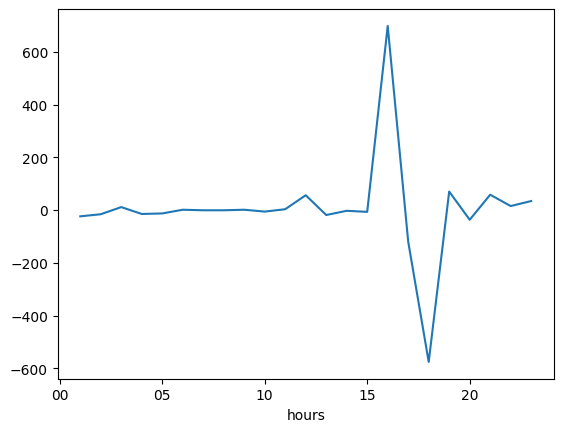

In [643]:
# evolution par heure
data.diff().plot()

In [644]:
data.diff().describe()

count     23.00000
mean       4.73913
std      196.42584
min     -576.00000
25%      -15.50000
50%       -1.00000
75%       13.00000
max      698.00000
Name: kWh, dtype: float64

<Axes: >

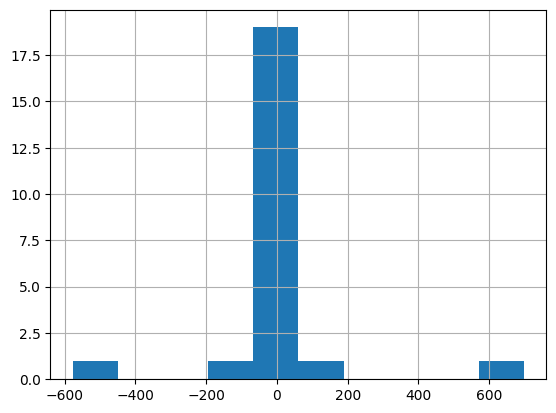

In [645]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [646]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [647]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

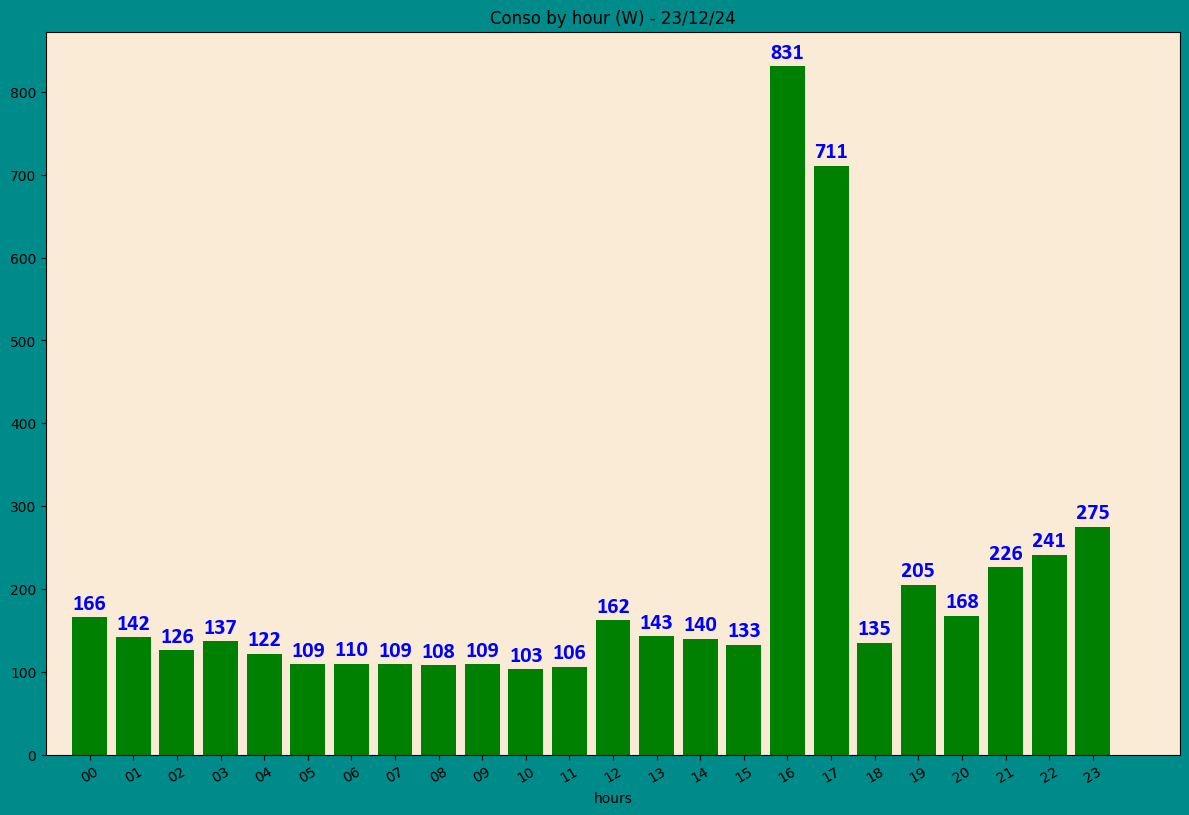

In [648]:
day,conso_byhour(day)

In [649]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


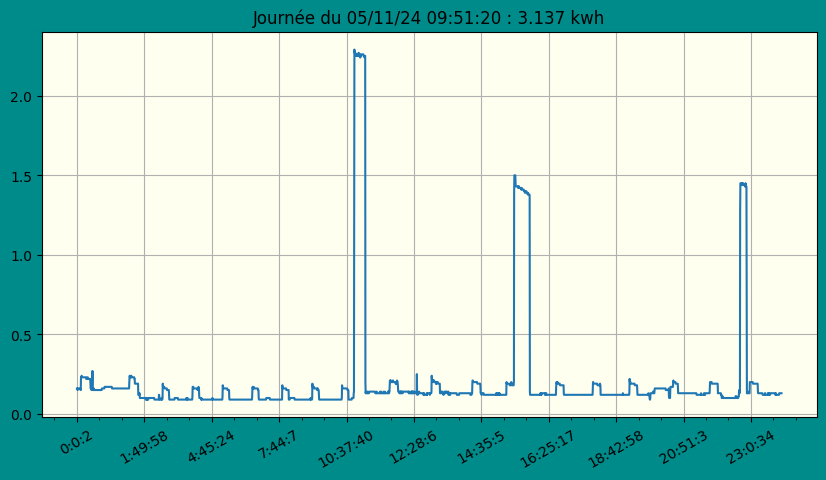

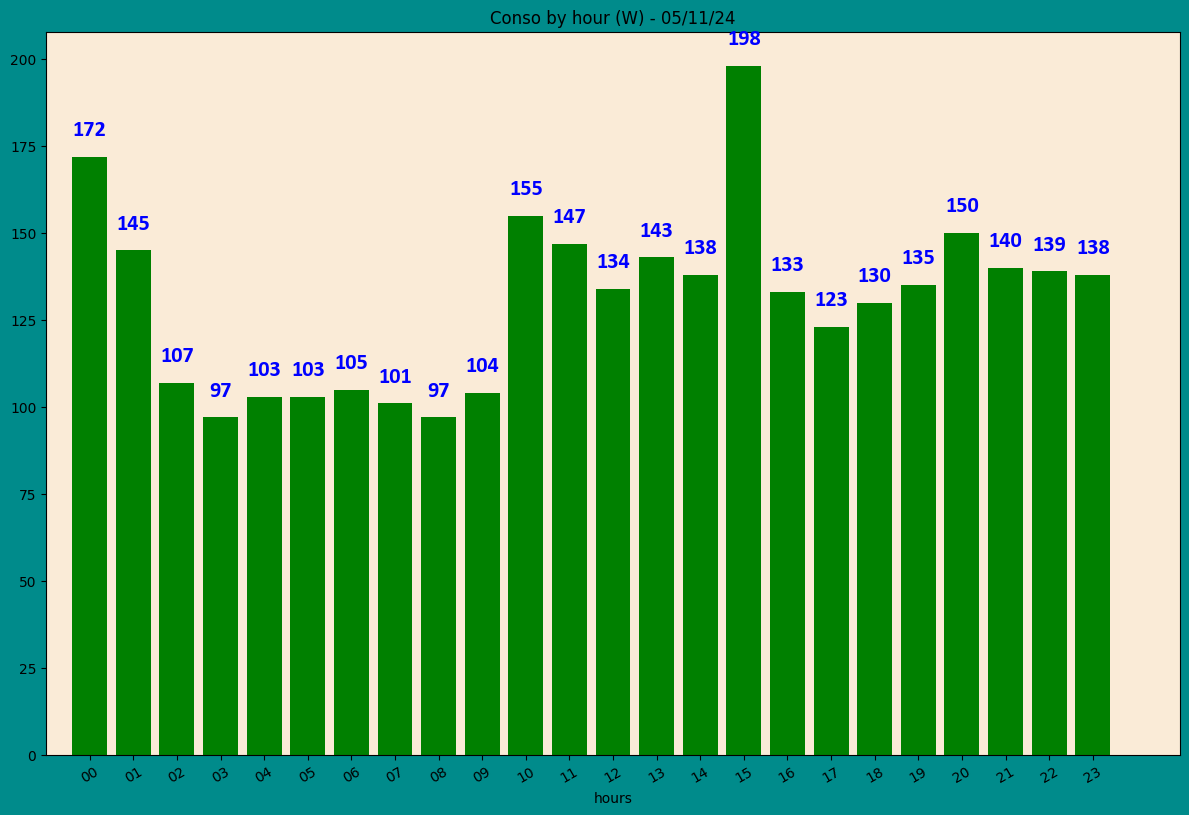

In [650]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [651]:
month

,day,hours,months,kWh
748577,01,00,2025-02,0.09
748578,01,00,2025-02,0.09
748579,01,00,2025-02,0.09
748580,01,00,2025-02,0.09
748581,01,00,2025-02,0.09
...,...,...,...,...
853077,28,23,2025-02,0.17
853078,28,23,2025-02,0.17
853079,28,23,2025-02,0.17
853080,28,23,2025-02,0.17


In [652]:
month.describe()


,kWh
count,104505.000000
mean,0.334552
std,0.555039
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

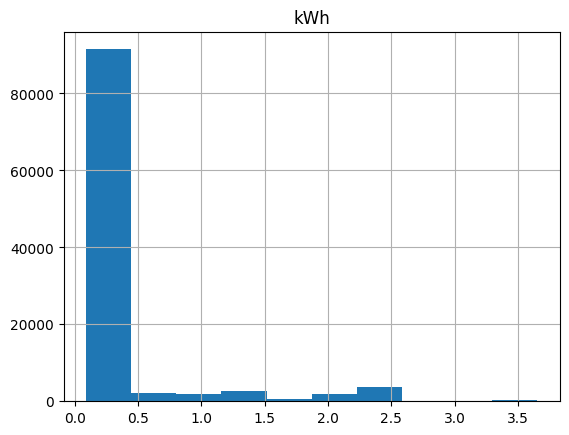

In [653]:
month.hist()

<Axes: >

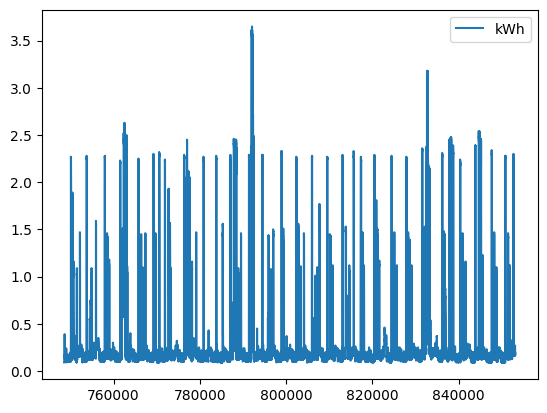

In [654]:
month.plot()

In [655]:
# index with max conso in this month
month.idxmax().kWh

np.int64(792090)

In [656]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       849637
hours     752174
months    748577
kWh       792090
dtype: int64

In [657]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [658]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
13/06/24 16      41      41   NaN   NaN
         17     139     180  98.0   NaN
         18     141     321   2.0   NaN
         19     174     495  33.0   NaN
         20     139     634 -35.0   NaN
...             ...     ...   ...   ...
12/04/25 05      98     609  -2.0   6.0
         06      98     707   0.0   7.0
         07      95     802  -3.0   8.0
         08      88     890  -7.0   9.0
         09     146    1036  58.0  10.0

[7266 rows x 4 columns]

In [659]:
month

,day,hours,months,kWh
748577,01,00,2025-02,0.09
748578,01,00,2025-02,0.09
748579,01,00,2025-02,0.09
748580,01,00,2025-02,0.09
748581,01,00,2025-02,0.09
...,...,...,...,...
853077,28,23,2025-02,0.17
853078,28,23,2025-02,0.17
853079,28,23,2025-02,0.17
853080,28,23,2025-02,0.17


In [660]:
month.idxmax()


day       849637
hours     752174
months    748577
kWh       792090
dtype: int64

In [661]:
month.loc[month.idxmax().kWh]


day            12
hours          15
months    2025-02
kWh          3.65
Name: 792090, dtype: object

In [662]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       150
          01       114
          02       108
          03       102
          04       111
          05       111
          06       104
          07       104
          08       111
          09       109
          10       181
          11       138
          12       149
          13       145
          14       198
          15       139
          16       195
          17       159
          18       148
          19       143
          20       161
          21       225
          22       174
          23       166
Name: kWh, dtype: int64

In [663]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'21'

<Axes: xlabel='days,hours'>

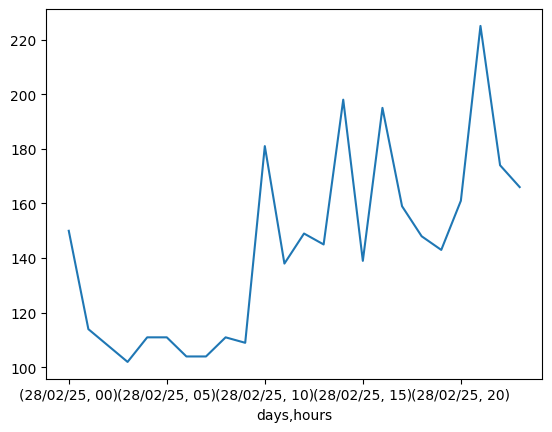

In [664]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [665]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [666]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [667]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [668]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB